In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy 
import random
import math
import csv
from scipy.stats import poisson 
import matplotlib as mpl
from matplotlib import colors as mpl_colors
import matplotlib
from scipy.stats import ttest_rel

# Set the pars and import the data

In [2]:
N_all = 4096
N = 64
n_tasks = 4
n_latent = 4
missing_exp = True
epochs = 500
plot_interpolation = "None"
inputs_dimension = 6


In [4]:
outputs = np.loadtxt('../Data/btb_experiments/outputs_BTB')
inputs = np.loadtxt('../Data/btb_experiments/inputs_BTB')
cell_inside = np.loadtxt('../Data/btb_experiments/cell_inside.csv')
surfaces_mLGCP_BTB = np.loadtxt('../Data/btb_experiments/surfaces_mLGCP_BTB')

In [5]:
rotated = list(reversed(zip(*cell_inside)))
matrix_rotated1 = np.zeros((N,N))
for i in  xrange(len(rotated)):
    matrix_rotated1[i,:] = rotated[i]
cell_inside = matrix_rotated1
cell_inside[cell_inside == 0] = np.nan

In [8]:
# Import outputs with missing data
data_final_with_NOna = outputs

# Import predictions for missing data exps

In [10]:
# If use covariates need to change this
method = 'MCPM'
prior_mixing_weights = 'Normal'
missing_exp = True 
n_folds = 16
n_missing_values = N_all/16


In [13]:
final_dataset_MT_Normal = np.load('../Data/btb_experiments/'+ 'final_dataset_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")
latent_means_MT_Normal = np.load('../Data/btb_experiments/' + 'latent_means_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")
latent_vars_MT_Normal = np.load('../Data/btb_experiments/' + 'latent_variances_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")
means_w_MT_Normal = np.load('../Data/btb_experiments/' + 'means_weights_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")
vars_w_MT_Normal = np.load('../Data/btb_experiments/' + 'covars_weights_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")
offsets_MT_Normal = np.load('../Data/btb_experiments/' + 'offsets_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")


In [21]:
method = 'LGCP'
prior_mixing_weights = 'Normal'
missing_exp = True 
n_folds = 16
n_missing_values = N_all/16

final_dataset_ST_Normal = np.load('../Data/btb_experiments/'+ 'final_dataset_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")
latent_means_ST_Normal = np.load('../Data/btb_experiments/' + 'latent_means_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")
latent_vars_ST_Normal = np.load('../Data/btb_experiments/' + 'latent_variances_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")
means_w_ST_Normal = np.load('../Data/btb_experiments/' + 'means_weights_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")
vars_w_ST_Normal = np.load('../Data/btb_experiments/' + 'covars_weights_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")
offsets_ST_Normal = np.load('../Data/btb_experiments/' + 'offsets_'+ prior_mixing_weights + "_" + 'MCPM' + "_" + str(missing_exp)+ ".npy")


In [22]:
# Import outputs with missing data
n_folds = 16
method = 'MT'
prior_mixing_weights = 'Normal'
missing_exp = True
data_final_with_na = np.loadtxt('../Data/btb_experiments/' + 'data_final_with_na_'+ prior_mixing_weights + "_" + method+ "_" + str(missing_exp)).reshape(n_folds, N_all, n_tasks + inputs_dimension)
data_final_with_na.shape

(16, 4096, 10)

In [23]:
data_NA = data_final_with_na[:]

In [24]:
fold = 0
na_data = np.zeros((n_tasks, N, N))
masked_array = np.zeros((n_tasks, N, N))
im = [None] * n_tasks
for t in xrange(n_tasks):
    na_data[t] = data_NA[fold,:,t+inputs_dimension].reshape(N,N)
    na_data[t][~np.isnan(na_data[t])] =  0
    na_data[t][np.isnan(na_data[t])] = 1
    na_data[t][na_data[t] == 0] =  np.nan
    
    masked_array[t] = np.ma.array(na_data[t], mask=np.isnan(data_final_with_na[fold,:,t+inputs_dimension].reshape(N,N)))


In [25]:
bounds = [None] * n_tasks
for t in xrange(n_tasks):
    bounds[t] = [0,np.max(data_final_with_NOna[:,t])/2, int(np.max(data_final_with_NOna[:,t]))]
bounds[0]

[0, 3.5, 7]

# Plot the data

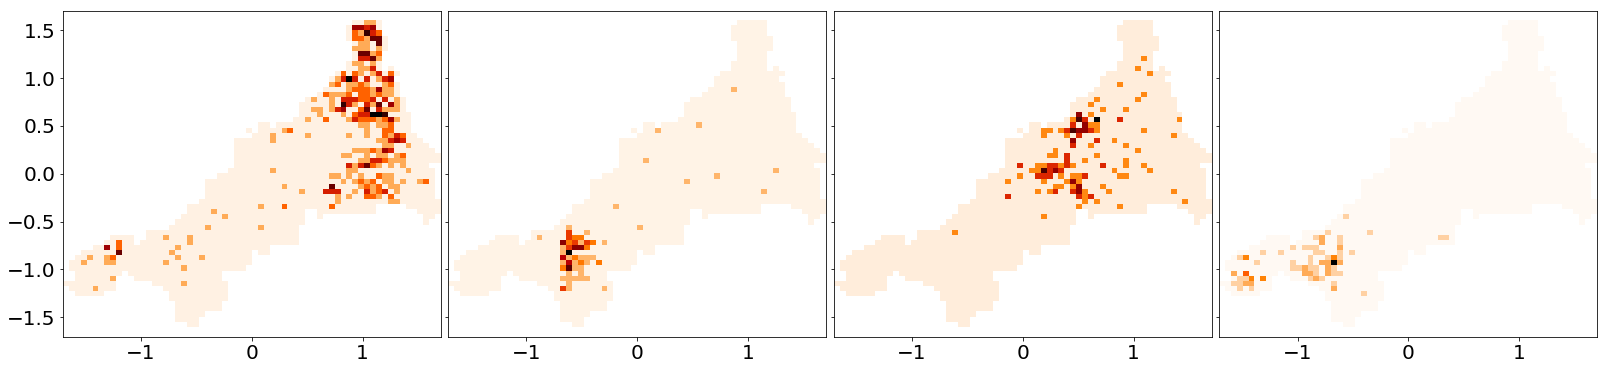

In [26]:
fold = 0
cmap = "gist_heat_r"
mpl.rcParams.update({'font.size': 20})
size_cbar_ticks = 18
transparency = 0.5
shrink = 0.8
pad=0.05
rescale = 0.2
cmap1 = mpl.cm.gray
cmap1.set_bad('white',alpha = 0.0)

xmin, xmax, ymin, ymax = np.amin(data_final_with_na[fold,:,1]), np.amax(data_final_with_na[fold,:,1]), np.amin(data_final_with_na[fold,:,0]), np.amax(data_final_with_na[fold,:,0])
extent = xmin, xmax, ymin, ymax

fig, axs = plt.subplots(1,4, sharex = 'col', sharey = 'row')
fig.set_figheight(6)
fig.set_figwidth(27.5)
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.02)

axs = axs.ravel()

for i in range(4):
#         print('i', i)
        color_max = np.amax((((data_final_with_NOna[:,i])[~np.isnan(data_final_with_NOna[:,i])])))
        color_min = np.amin((((data_final_with_NOna[:,i])[~np.isnan(data_final_with_NOna[:,i])])))
#         print('color_max', color_max)
#         print('color_min', color_min)
        color_min = color_min - rescale
        
        im[i] = axs[i].imshow(data_final_with_NOna[:, i].reshape(N,N)*cell_inside, extent=extent, 
                 aspect = 'auto', cmap=cmap, interpolation='None',
                 vmin = color_min, vmax = color_max)
        
        #axs[i].imshow(masked_array[i], interpolation='nearest', cmap = cmap1, alpha = transparency,
        #  extent=extent)
        
        #axs[i].title.set_text(crime_list_name[i])
        

        #b = bounds[i]
        #cbar = plt.colorbar(im[i], ax = axs[i],orientation="horizontal", pad=pad, shrink = shrink, ticks = b)
        #cbar.ax.tick_params(labelsize=size_cbar_ticks)

#         axs[i].set_yticks([])
#         axs[i].set_xticks([])         
plt.show()

In [27]:
# Estimated surfaces ST

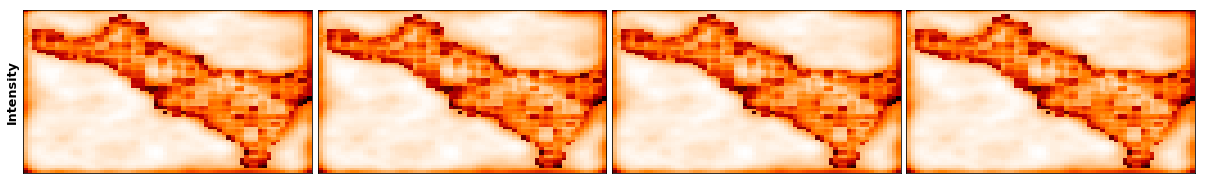

In [28]:
fold = 0
mpl.rcParams.update({'font.size': 12.8})
size_cbar_ticks = 15
rescale = 20

cmap = "gist_heat_r"
norm = mpl.colors.Normalize(vmin=-100.,vmax=100)

extent = (np.amin(final_dataset_ST_Normal[fold,:,0]), np.amax(final_dataset_ST_Normal[fold,:,0]), np.amin(final_dataset_ST_Normal[fold,:,1]), np.amax(final_dataset_ST_Normal[fold,:,1]))

fig, axs = plt.subplots(1,4, sharex = 'col', sharey = 'row')
fig.set_figheight(3)
fig.set_figwidth(21)
fig.subplots_adjust(hspace=0.02)
fig.subplots_adjust(wspace=0.02)

axs = axs.ravel()

for i in range(n_tasks):
#     print('i',i)
#     print('i +9',i + 9)
#     print('to plot',final_dataset_ST_Normal[fold,:, inputs_dimension + n_tasks + i ][~np.isnan(final_dataset_ST_Normal[fold,:, inputs_dimension + n_tasks + i])])
    color_max = np.amax((final_dataset_ST_Normal[fold,:, inputs_dimension + n_tasks + i][~np.isnan(final_dataset_ST_Normal[fold,:, inputs_dimension + n_tasks + i])]))

    color_min = np.amin((final_dataset_ST_Normal[fold,:, inputs_dimension + n_tasks + i][~np.isnan(final_dataset_ST_Normal[fold,:, inputs_dimension + n_tasks + i])]))
#     print('min',color_max) 
#     print('max',color_min)

    axs[i].imshow(final_dataset_ST_Normal[fold,:, inputs_dimension + n_tasks + i].reshape(N,N), extent=extent, aspect = 'auto', 
                  cmap=cmap, interpolation='None', vmin = color_min, vmax = color_max)
    #axs[i].title.set_text(crime_list_name[i])
    if i == 0:
        axs[i].set_ylabel('Intensity', fontweight="bold")


    axs[i].grid(False)
    axs[i].set_yticks([]) 
    axs[i].set_xticks([]) 
    axs[i].grid(False)
    
# name = "Figure3" + str(cmap)
# fig.savefig(name + '.png')
plt.show()

# Evaluation of performance missing data exp

In [29]:
mean_outputs = np.mean(outputs, axis = 0)
range_outputs = np.ptp(outputs, axis = 0)
mean_outputs

array([0.12060547, 0.02661133, 0.04052734, 0.02539062])

In [30]:
np.random.seed(1)
# cell_bool = np.ones((N, N))

In [31]:
cell_inside[~np.isnan(cell_inside)] = True
cell_inside[np.isnan(cell_inside)] = False


In [34]:
MT_RMSE_results_inter = np.zeros((n_tasks, n_folds))
MT_NLPL_results_inter = np.zeros((n_tasks, n_folds))
MT_RMSE_results = np.zeros((n_tasks))
MT_NLPL_results = np.zeros((n_tasks))

ST_RMSE_results = np.zeros((n_tasks))
ST_NLPL_results = np.zeros((n_tasks))
ST_RMSE_results_inter = np.zeros((n_tasks, n_folds))
ST_NLPL_results_inter = np.zeros((n_tasks, n_folds))

In [35]:
n_folds = 16
for fold in xrange(n_folds):

    for task in xrange(n_tasks):
        fold_task_subset = data_final_with_na[fold,:,task+inputs_dimension]
        #cond = np.isnan(fold_task_subset)
        cond = np.logical_and(cell_inside, np.isnan(fold_task_subset).reshape(N,N)).reshape(N_all,1)[:,0]
#         print('cond',cond.shape)
#         print('outputs',outputs.shape)
        true_counts =  outputs[cond,task] 
#         print('true',true_counts.shape)
#         print('final_dataset_ST_Normal',final_dataset_ST_Normal.shape)
        pred_counts =  final_dataset_ST_Normal[fold,cond,inputs_dimension + n_tasks + task]
        #print('pred_counts',pred_counts.shape)
        
        if pred_counts.shape[0] == 0:
            ST_NLPL_results_inter[task,fold] = np.nan
            ST_RMSE_results_inter[task,fold] = np.nan 
        else:
            ST_NLPL_results_inter[task,fold] = - np.sum(poisson.logpmf(true_counts, pred_counts))/pred_counts.shape[0]
            ST_RMSE_results_inter[task,fold] = np.sqrt(np.sum(np.square(true_counts - pred_counts))/pred_counts.shape[0])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [27]:
for t in xrange(n_tasks):
    ST_RMSE_results[t] = np.mean(ST_RMSE_results_inter[t][~np.isnan(ST_RMSE_results_inter[t])])
print('ST_RMSE_results mean', ST_RMSE_results)

('ST_RMSE_results mean', array([1.36595096, 0.61123246, 0.62951459, 1.24458678]))


In [28]:
for t in xrange(n_tasks):
    ST_NLPL_results[t] = np.mean(ST_NLPL_results_inter[t][~np.isnan(ST_NLPL_results_inter[t])])
print('ST_NLPL_results mean', ST_NLPL_results)

('ST_NLPL_results mean', array([1.12466775, 0.40336858, 0.45393265, 0.75611052]))


In [29]:
for t in xrange(n_tasks):
    ST_RMSE_results[t] = np.std(ST_RMSE_results_inter[t][~np.isnan(ST_RMSE_results_inter[t])])/np.sqrt(n_folds)
print('ST_RMSE_results std', ST_RMSE_results)

('ST_RMSE_results std', array([0.32697541, 0.13047572, 0.11845203, 0.5575689 ]))


In [30]:
for t in xrange(n_tasks):
    ST_NLPL_results[t] = np.std(ST_NLPL_results_inter[t][~np.isnan(ST_NLPL_results_inter[t])])/np.sqrt(n_folds)
print('ST_NLPL_results std', ST_NLPL_results)

('ST_NLPL_results std', array([0.22416308, 0.07868817, 0.08231063, 0.31167259]))


In [39]:
## Evaluate results for MT
n_folds = 16
for fold in xrange(n_folds):

    for task in xrange(n_tasks):
        fold_task_subset = data_final_with_na[fold,:,task+inputs_dimension]
        #cond = np.isnan(fold_task_subset)
        cond = np.logical_and(cell_inside, np.isnan(fold_task_subset).reshape(N,N)).reshape(N_all,1)[:,0]
#         print('cond',cond.shape)
#         print('outputs',outputs.shape)
        true_counts =  outputs[cond,task] 
#         print('true',true_counts.shape)
#         print('final_dataset_ST_Normal',final_dataset_ST_Normal.shape)
        pred_counts =  final_dataset_MT_Normal[fold,cond,inputs_dimension + n_tasks + task]
#         print('pred_counts',pred_counts.shape)
        if pred_counts.shape[0] == 0:
            MT_NLPL_results_inter[task,fold] = np.nan
            MT_RMSE_results_inter[task,fold] = np.nan 
        else:
            MT_NLPL_results_inter[task,fold] = - np.sum(poisson.logpmf(true_counts, pred_counts))/pred_counts.shape[0]
            MT_RMSE_results_inter[task,fold] = np.sqrt(np.sum(np.square(true_counts - pred_counts))/pred_counts.shape[0])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [34]:
for t in xrange(n_tasks):
    MT_RMSE_results[t] = np.mean(MT_RMSE_results_inter[t][~np.isnan(MT_RMSE_results_inter[t])])
print('MT_RMSE_results mean', MT_RMSE_results)

('MT_RMSE_results mean', array([0.75975862, 0.22559239, 0.27148854, 0.27075389]))


In [36]:
for t in xrange(n_tasks):
    MT_NLPL_results[t] = np.mean(MT_NLPL_results_inter[t][~np.isnan(MT_NLPL_results_inter[t])])
print('MT_NLPL_results mean', MT_NLPL_results)

('MT_NLPL_results mean', array([1.02420264, 0.16651913, 0.28661342, 0.29611546]))


In [38]:
for t in xrange(n_tasks):
    MT_RMSE_results[t] = np.std(MT_RMSE_results_inter[t][~np.isnan(MT_RMSE_results_inter[t])])/np.sqrt(n_folds)
print('MT_RMSE_results std', MT_RMSE_results)

('MT_RMSE_results std', array([0.14632862, 0.07307546, 0.06838324, 0.09665354]))


In [40]:
for t in xrange(n_tasks):
    MT_NLPL_results[t] = np.std(MT_NLPL_results_inter[t][~np.isnan(MT_NLPL_results_inter[t])])/np.sqrt(n_folds)
print('MT_NLPL_results std', MT_NLPL_results)

('MT_NLPL_results std', array([0.32985675, 0.05428784, 0.09684123, 0.13582312]))


# Import results form ICM

In [40]:
mu = np.load('../Data/btb_experiments/posterior_mean.npy')
var = np.load('../Data/btb_experiments/posterior_var.npy')


posterior_mean = np.exp(mu + 0.5*var)
posterior_var = (np.exp(var) - 1.)*np.exp(2.0*mu + var)

# Missing data MT plot

In [41]:
fold = 0

In [42]:
MT_pred_vector = final_dataset_MT_Normal[:,:,(inputs_dimension + n_tasks):(inputs_dimension + n_tasks + n_tasks)]
MT_pred_vector.shape
ST_pred_vector = final_dataset_ST_Normal[:,:,(inputs_dimension + n_tasks):(inputs_dimension + n_tasks + n_tasks)]
ST_pred_vector.shape

(1, 4096, 4)

In [43]:
cp1_MTCP = (MT_pred_vector[fold,:,0].reshape(64,64))/ (MT_pred_vector[fold,:,0].reshape(64,64) + MT_pred_vector[fold,:,1].reshape(64,64) + MT_pred_vector[fold,:,2].reshape(64,64) + MT_pred_vector[fold,:,3].reshape(64,64)) 
cp2_MTCP = (MT_pred_vector[fold,:,1].reshape(64,64))/ (MT_pred_vector[fold,:,0].reshape(64,64) + MT_pred_vector[fold,:,1].reshape(64,64) + MT_pred_vector[fold,:,2].reshape(64,64) + MT_pred_vector[fold,:,3].reshape(64,64)) 
cp3_MTCP = (MT_pred_vector[fold,:,2].reshape(64,64))/ (MT_pred_vector[fold,:,0].reshape(64,64) + MT_pred_vector[fold,:,1].reshape(64,64) + MT_pred_vector[fold,:,2].reshape(64,64) + MT_pred_vector[fold,:,3].reshape(64,64)) 
cp4_MTCP = (MT_pred_vector[fold,:,3].reshape(64,64))/ (MT_pred_vector[fold,:,0].reshape(64,64) + MT_pred_vector[fold,:,1].reshape(64,64) + MT_pred_vector[fold,:,2].reshape(64,64) + MT_pred_vector[fold,:,3].reshape(64,64)) 


In [44]:
cp1_ICM = (posterior_mean[fold,:,0].reshape(64,64))/ (posterior_mean[fold,:,0].reshape(64,64) + posterior_mean[fold,:,1].reshape(64,64) + posterior_mean[fold,:,2].reshape(64,64) + posterior_mean[fold,:,3].reshape(64,64)) 
cp2_ICM = (posterior_mean[fold,:,1].reshape(64,64))/ (posterior_mean[fold,:,0].reshape(64,64) + posterior_mean[fold,:,1].reshape(64,64) + posterior_mean[fold,:,2].reshape(64,64) + posterior_mean[fold,:,3].reshape(64,64)) 
cp3_ICM = (posterior_mean[fold,:,2].reshape(64,64))/ (posterior_mean[fold,:,0].reshape(64,64) + posterior_mean[fold,:,1].reshape(64,64) + posterior_mean[fold,:,2].reshape(64,64) + posterior_mean[fold,:,3].reshape(64,64)) 
cp4_ICM = (posterior_mean[fold,:,3].reshape(64,64))/ (posterior_mean[fold,:,0].reshape(64,64) + posterior_mean[fold,:,1].reshape(64,64) + posterior_mean[fold,:,2].reshape(64,64) + posterior_mean[fold,:,3].reshape(64,64)) 


In [45]:
na_task1 = data_final_with_na[fold,:,inputs_dimension].reshape(64,64)
na_task2 = data_final_with_na[fold,:,inputs_dimension+1].reshape(64,64)
na_task3 = data_final_with_na[fold,:,inputs_dimension+2].reshape(64,64)
na_task4 = data_final_with_na[fold,:,inputs_dimension+3].reshape(64,64)

In [46]:
na_task1[~np.isnan(na_task1)] =  0
na_task1[np.isnan(na_task1)] = 1
na_task1[na_task1 == 0] =  np.nan
na_task2[~np.isnan(na_task2)] =  0
na_task2[np.isnan(na_task2)] = 1
na_task2[na_task2 == 0] =  np.nan
na_task3[~np.isnan(na_task3)] =  0
na_task3[np.isnan(na_task3)] = 1
na_task3[na_task3 == 0] =  np.nan
na_task4[~np.isnan(na_task4)] =  0
na_task4[np.isnan(na_task4)] = 1
na_task4[na_task4 == 0] =  np.nan

# This get the plot for the missing data experimemnt. Changing the data that are imported one can make the plot with covariate or no covariates. When using the cov the plot creates a problem in the first row. 

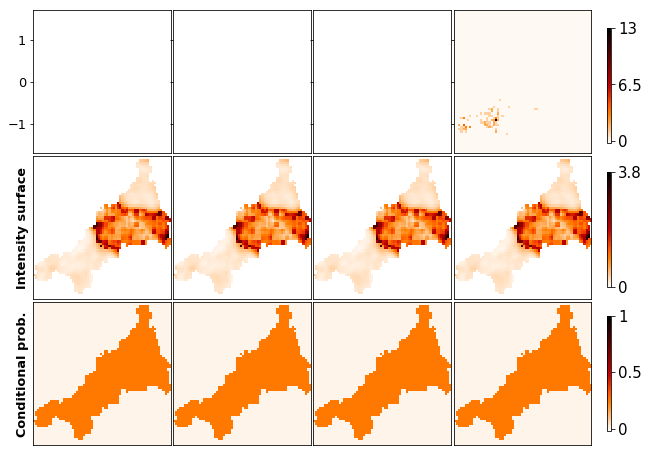

In [47]:
#cmap = 'jet'
cmap = "gist_heat_r"

inducing = 'ind'
f, ((ax01,ax02,ax03,ax04),(ax3, ax5, ax7, ax9),(ax10,ax11,ax12,ax13)) = plt.subplots(3, 4, sharex = 'col', sharey = 'row')

xmin, xmax, ymin, ymax = np.amin(data_final_with_na[fold,:,1]), np.amax(data_final_with_na[fold,:,1]), np.amin(data_final_with_na[fold,:,0]), np.amax(data_final_with_na[fold,:,0])
extent = xmin, xmax, ymin, ymax

f.set_figheight(8)
f.set_figwidth(10)


color_max = np.amax(((((outputs[:,0].reshape(N,N))*cell_inside)[~np.isnan(outputs[:,0].reshape(N,N)*cell_inside)],
                                    (outputs[:,1].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,1].reshape(N,N)*cell_inside)],
                                    (outputs[:,2].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,2].reshape(N,N)*cell_inside)],
                                    (outputs[:,3].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,3].reshape(N,N)*cell_inside)])))

color_min = np.amin((((outputs[:,0].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,0].reshape(N,N)*cell_inside)],
                                    (outputs[:,1].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,1].reshape(N,N)*cell_inside)],
                                    (outputs[:,2].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,2].reshape(N,N)*cell_inside)],
                                    (outputs[:,3].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,3].reshape(N,N)*cell_inside)])))
color_min = color_min - 0.2

# masked_array1 = np.ma.array(na_task1, mask=np.isnan(outputs[:,0].reshape(N,N)))
# masked_array2 = np.ma.array(na_task2, mask=np.isnan(outputs[:,1].reshape(N,N)))
# masked_array3 = np.ma.array(na_task3, mask=np.isnan(outputs[:,2].reshape(N,N)))
# masked_array4 = np.ma.array(na_task4, mask=np.isnan(outputs[:,3].reshape(N,N)))


# cmap1 = matplotlib.cm.gray
# cmap1.set_bad('white',alpha = 0.0)

# ax01.imshow(outputs[:,0].reshape(N,N)*cell_inside, 
#                  aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
#           extent=extent)

# ax01.imshow(masked_array1, interpolation='nearest', cmap = cmap1, alpha = transparency,
#           extent=extent)

# ax01.set_yticks([]) 
# ax01.set_xticks([]) 
# ax01.set_title('GT 9', size=15)
# ax01.set_ylabel('Training obs.', fontweight="bold")



# ax02.imshow(outputs[:,1].reshape(N,N)*cell_inside, 
#                  aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
#           extent=extent)

# ax02.imshow(masked_array2, interpolation='nearest', cmap = cmap1, alpha = transparency,
#           extent=extent)
# # ax2.spines['top'].set_visible(False)
# # ax2.spines['right'].set_visible(False)
# ax02.set_yticks([]) 
# ax02.set_xticks([]) 
# #ax2.title.set_text('GT 12')
# ax02.set_title('GT 12', size=15)


# ax03.imshow(outputs[:,2].reshape(N,N)*cell_inside, 
#                  aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
#           extent=extent)

# ax03.imshow(masked_array3, interpolation='nearest', cmap = cmap1, alpha = transparency,
#           extent=extent)
# # ax3.spines['top'].set_visible(False)
# # ax3.spines['right'].set_visible(False)
# ax03.set_yticks([]) 
# ax03.set_xticks([]) 
# #ax3.title.set_text('GT 15')
# ax03.set_title('GT 15', size=15)



img = ax04.imshow(outputs[:,3].reshape(N,N)*cell_inside, 
                 aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
          extent=extent)

# ax04.imshow(masked_array4, interpolation='nearest', cmap = cmap1, alpha = transparency,
#           extent=extent)
# # ax4.spines['top'].set_visible(False)
# # ax4.spines['right'].set_visible(False)

# ax04.set_yticks([]) 
# ax04.set_xticks([]) 
# ax04.set_title('GT 20', size=15)
# # ax4.title.set_text('GT 20', size=20)


bounds = [0, 6.5, 13]
cax = f.add_axes([0.9, 0.65, 0.05, 0.2], aspect=30)
cbar = plt.colorbar(img, cax=cax, ticks = bounds)
cbar.ax.set_yticklabels(['0', '6.5', '13'])  # vertically oriented colorbar
cbar.ax.tick_params(labelsize=15)


color_max = np.amax((np.concatenate((MT_pred_vector[fold,:,0].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,0].reshape(N_all,))],
                                    MT_pred_vector[fold,:,1].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,1].reshape(N_all,))],
                                    MT_pred_vector[fold,:,2].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,2].reshape(N_all,))],
                                    MT_pred_vector[fold,:,3].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,3].reshape(N_all,))]))))

color_min = np.amin((np.concatenate((MT_pred_vector[fold,:,0].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,0].reshape(N_all,))],
                                    MT_pred_vector[fold,:,1].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,1].reshape(N_all,))],
                                    MT_pred_vector[fold,:,2].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,2].reshape(N_all,))],
                                    MT_pred_vector[fold,:,3].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,3].reshape(N_all,))]))))


color_min = color_min - 0.2
im1 = ax3.imshow(MT_pred_vector[fold,:,0].reshape(64,64)* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax3.grid(False)
ax3.xaxis.set_visible(True)
ax3.tick_params(labelsize=8)
#ax3.title.set_text('GT 9')
ax3.set_yticks([]) 
ax3.set_xticks([]) 
ax3.set_ylabel('Intensity surface', fontweight="bold")




ax5.imshow(MT_pred_vector[fold,:,1].reshape(64,64)* cell_inside, extent=extent, 
           aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax5.grid(False)
ax5.xaxis.set_visible(True)
ax5.tick_params(labelsize=8)
#ax5.title.set_text('GT 12')
ax5.set_yticks([]) 
ax5.set_xticks([]) 




ax7.imshow(MT_pred_vector[fold,:,2].reshape(64,64)* cell_inside, extent=extent, 
           aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax7.grid(False)
ax7.xaxis.set_visible(True)
ax7.tick_params(labelsize=8)
#ax7.title.set_text('GT 15')
ax7.set_yticks([]) 
ax7.set_xticks([]) 



ax9.imshow(MT_pred_vector[fold,:,3].reshape(64,64)* cell_inside, extent=extent, 
           aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax9.grid(False)
ax9.xaxis.set_visible(True)
ax9.tick_params(labelsize=8)
#ax9.title.set_text('GT 20')
ax9.set_yticks([]) 
ax9.set_xticks([]) 


bounds = [color_min, (color_max-color_min)/2, color_max]
cax2 = f.add_axes([0.9, 0.40, 0.05, 0.2], aspect=30)
cbar = plt.colorbar(im1, cax=cax2, ticks = bounds)
cbar.ax.set_yticklabels(['0', '3.8', '7.8'])  # vertically oriented colorbar
cbar.ax.tick_params(labelsize=15)

######
color_max = 1
color_min = 0 -0.02

im2 = ax10.imshow(cp1_MTCP* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax10.grid(False)
ax10.xaxis.set_visible(True)
ax10.tick_params(labelsize=8)
ax10.set_yticks([]) 
ax10.set_xticks([]) 
ax10.set_ylabel('Conditional prob.', fontweight="bold")



ax11.imshow(cp2_MTCP* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax11.grid(False)
ax11.xaxis.set_visible(True)
ax11.tick_params(labelsize=8)
ax11.set_yticks([]) 
ax11.set_xticks([]) 

ax12.imshow(cp3_MTCP* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax12.grid(False)
ax12.xaxis.set_visible(True)
ax12.tick_params(labelsize=8)
ax12.set_yticks([]) 
ax12.set_xticks([]) 

ax13.imshow(cp4_MTCP* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax13.grid(False)
ax13.xaxis.set_visible(True)
ax13.tick_params(labelsize=8)
ax13.set_yticks([]) 
ax13.set_xticks([]) 



bounds = [0, 0.5, 1]
cax2 = f.add_axes([0.9, 0.15, 0.05, 0.2], aspect=30)
cbar = plt.colorbar(im2, cax=cax2, ticks = bounds)
cbar.ax.set_yticklabels(['0', '0.5', '1'])  # vertically oriented colorbar
cbar.ax.tick_params(labelsize=15)


f.subplots_adjust(hspace=0.02)
f.subplots_adjust(wspace=0.02)


#name = "BTB_missing_exp_inducing"+ inducing + str(cmap)
#f.savefig(name + '.png')

plt.show()

# Plot missing setting for paper

('colormax', 30.759510040283203)
('color_min', 13.187155723571777)


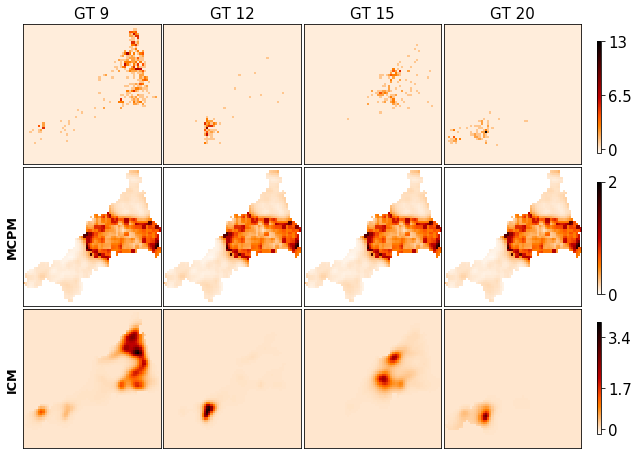

In [50]:
### cmap = 'jet'
cmap = "gist_heat_r"

inducing = 'ind'
f, ((ax01,ax02,ax03,ax04),(ax3, ax5, ax7, ax9),(ax10,ax11,ax12,ax13)) = plt.subplots(3, 4, sharex = 'col', sharey = 'row')

xmin, xmax, ymin, ymax = np.amin(data_final_with_na[fold,:,1]), np.amax(data_final_with_na[fold,:,1]), np.amin(data_final_with_na[fold,:,0]), np.amax(data_final_with_na[fold,:,0])
extent = xmin, xmax, ymin, ymax

f.set_figheight(7.8)
f.set_figwidth(10)


color_max = np.amax(((((outputs[:,0].reshape(N,N))*cell_inside)[~np.isnan(outputs[:,0].reshape(N,N)*cell_inside)],
                                    (outputs[:,1].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,1].reshape(N,N)*cell_inside)],
                                    (outputs[:,2].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,2].reshape(N,N)*cell_inside)],
                                    (outputs[:,3].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,3].reshape(N,N)*cell_inside)])))

color_min = np.amin((((outputs[:,0].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,0].reshape(N,N)*cell_inside)],
                                    (outputs[:,1].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,1].reshape(N,N)*cell_inside)],
                                    (outputs[:,2].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,2].reshape(N,N)*cell_inside)],
                                    (outputs[:,3].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,3].reshape(N,N)*cell_inside)])))
color_min = color_min - 0.5

masked_array1 = np.ma.array(na_task1, mask=np.isnan(outputs[:,0].reshape(N,N)))
masked_array2 = np.ma.array(na_task2, mask=np.isnan(outputs[:,1].reshape(N,N)))
masked_array3 = np.ma.array(na_task3, mask=np.isnan(outputs[:,2].reshape(N,N)))
masked_array4 = np.ma.array(na_task4, mask=np.isnan(outputs[:,3].reshape(N,N)))


#### DATA

ax01.imshow(outputs[:,0].reshape(N,N)*cell_inside, 
                 aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
          extent=extent)

#ax01.imshow(masked_array1, interpolation='nearest', cmap = cmap1, alpha = transparency,
#          extent=extent)

ax01.set_yticks([]) 
ax01.set_xticks([]) 
ax01.set_title('GT 9', size=15)
#ax01.set_ylabel('Training obs.', fontweight="bold")



ax02.imshow(outputs[:,1].reshape(N,N)*cell_inside, 
                 aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
          extent=extent)

#ax02.imshow(masked_array2, interpolation='nearest', cmap = cmap1, alpha = transparency,
 #         extent=extent)
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax02.set_yticks([]) 
ax02.set_xticks([]) 
#ax2.title.set_text('GT 12')
ax02.set_title('GT 12', size=15)


ax03.imshow(outputs[:,2].reshape(N,N)*cell_inside, 
                 aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
          extent=extent)

#ax03.imshow(masked_array3, interpolation='nearest', cmap = cmap1, alpha = transparency,
 #         extent=extent)
# ax3.spines['top'].set_visible(False)
# ax3.spines['right'].set_visible(False)
ax03.set_yticks([]) 
ax03.set_xticks([]) 
#ax3.title.set_text('GT 15')
ax03.set_title('GT 15', size=15)



img = ax04.imshow(outputs[:,3].reshape(N,N)*cell_inside, 
                 aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
          extent=extent)

#ax04.imshow(masked_array4, interpolation='nearest', cmap = cmap1, alpha = transparency,
#          extent=extent)
# ax4.spines['top'].set_visible(False)
# ax4.spines['right'].set_visible(False)

ax04.set_yticks([]) 
ax04.set_xticks([]) 
ax04.set_title('GT 20', size=15)
# ax4.title.set_text('GT 20', size=20)


#### MT predictions

bounds = [0, 6.5, 13]
cax = f.add_axes([0.9, 0.65, 0.05, 0.2], aspect=30)
cbar = plt.colorbar(img, cax=cax, ticks = bounds)
cbar.ax.set_yticklabels(['0', '6.5', '13'])  # vertically oriented colorbar
cbar.ax.tick_params(labelsize=15)


color_max = np.amax((np.concatenate((MT_pred_vector[fold,:,0].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,0].reshape(N_all,))],
                                    MT_pred_vector[fold,:,1].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,1].reshape(N_all,))],
                                    MT_pred_vector[fold,:,2].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,2].reshape(N_all,))],
                                    MT_pred_vector[fold,:,3].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,3].reshape(N_all,))]))))

color_min = np.amin((np.concatenate((MT_pred_vector[fold,:,0].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,0].reshape(N_all,))],
                                    MT_pred_vector[fold,:,1].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,1].reshape(N_all,))],
                                    MT_pred_vector[fold,:,2].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,2].reshape(N_all,))],
                                    MT_pred_vector[fold,:,3].reshape(N_all,)[~np.isnan(MT_pred_vector[fold,:,3].reshape(N_all,))]))))

print('colormax', color_max)
print('color_min', color_min)
color_min = color_min - 0.2
im1 = ax3.imshow(MT_pred_vector[fold,:,0].reshape(64,64)* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax3.grid(False)
ax3.xaxis.set_visible(True)
ax3.tick_params(labelsize=8)
#ax3.title.set_text('GT 9')
ax3.set_yticks([]) 
ax3.set_xticks([]) 
ax3.set_ylabel('MCPM', fontweight="bold")




ax5.imshow(MT_pred_vector[fold,:,1].reshape(64,64)* cell_inside, extent=extent, 
           aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax5.grid(False)
ax5.xaxis.set_visible(True)
ax5.tick_params(labelsize=8)
#ax5.title.set_text('GT 12')
ax5.set_yticks([]) 
ax5.set_xticks([]) 




ax7.imshow(MT_pred_vector[fold,:,2].reshape(64,64)* cell_inside, extent=extent, 
           aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax7.grid(False)
ax7.xaxis.set_visible(True)
ax7.tick_params(labelsize=8)
#ax7.title.set_text('GT 15')
ax7.set_yticks([]) 
ax7.set_xticks([]) 



ax9.imshow(MT_pred_vector[fold,:,3].reshape(64,64)* cell_inside, extent=extent, 
           aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax9.grid(False)
ax9.xaxis.set_visible(True)
ax9.tick_params(labelsize=8)
#ax9.title.set_text('GT 20')
ax9.set_yticks([]) 
ax9.set_xticks([]) 


bounds = [color_min, (color_max-color_min)/2, color_max]
cax2 = f.add_axes([0.9, 0.40, 0.05, 0.2], aspect=30)
cbar = plt.colorbar(im1, cax=cax2, ticks = bounds)
cbar.ax.set_yticklabels(['0', '2', '4'])  # vertically oriented colorbar
cbar.ax.tick_params(labelsize=15)

#### Predictions ST

color_max = np.amax((np.concatenate((posterior_mean[fold,:,0].reshape(N_all,)[~np.isnan(posterior_mean[fold,:,0].reshape(N_all,))],
                                    posterior_mean[fold,:,1].reshape(N_all,)[~np.isnan(posterior_mean[fold,:,1].reshape(N_all,))],
                                    posterior_mean[fold,:,2].reshape(N_all,)[~np.isnan(posterior_mean[fold,:,2].reshape(N_all,))],
                                    posterior_mean[fold,:,3].reshape(N_all,)[~np.isnan(posterior_mean[fold,:,3].reshape(N_all,))]))))

color_min = np.amin((np.concatenate((posterior_mean[fold,:,0].reshape(N_all,)[~np.isnan(posterior_mean[fold,:,0].reshape(N_all,))],
                                    posterior_mean[fold,:,1].reshape(N_all,)[~np.isnan(posterior_mean[fold,:,1].reshape(N_all,))],
                                    posterior_mean[fold,:,2].reshape(N_all,)[~np.isnan(posterior_mean[fold,:,2].reshape(N_all,))],
                                    posterior_mean[fold,:,3].reshape(N_all,)[~np.isnan(posterior_mean[fold,:,3].reshape(N_all,))]))))

color_min = color_min - 0.2
im2 = ax10.imshow(posterior_mean[fold,:,0].reshape(N,N)* cell_inside, 
                  extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
                  vmin = color_min, vmax = color_max)
ax10.grid(False)
ax10.xaxis.set_visible(True)
ax10.tick_params(labelsize=8)
ax10.set_yticks([]) 
ax10.set_xticks([]) 
ax10.set_ylabel('ICM', fontweight="bold")


ax11.imshow(posterior_mean[fold,:,1].reshape(N,N)* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax11.grid(False)
ax11.xaxis.set_visible(True)
ax11.tick_params(labelsize=8)
ax11.set_yticks([]) 
ax11.set_xticks([]) 



ax12.imshow(posterior_mean[fold,:,2].reshape(N,N)* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax12.grid(False)
ax12.xaxis.set_visible(True)
ax12.tick_params(labelsize=8)
ax12.set_yticks([]) 
ax12.set_xticks([]) 


ax13.imshow(posterior_mean[fold,:,3].reshape(N,N)* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax13.grid(False)
ax13.xaxis.set_visible(True)
ax13.tick_params(labelsize=8)
ax13.set_yticks([]) 
ax13.set_xticks([]) 



bounds = [0, 1.5, 3.39]
cax2 = f.add_axes([0.9, 0.15, 0.05, 0.2], aspect=30)
cbar = plt.colorbar(im2, cax=cax2, ticks = bounds)
cbar.ax.set_yticklabels(['0', '1.7', '3.4'])  # vertically oriented colorbar
cbar.ax.tick_params(labelsize=15)


f.subplots_adjust(hspace=0.02)
f.subplots_adjust(wspace=0.02)


#name = "BTB_missing_exp_inducing_intensities_LGCPN_ICM"+ inducing + str(cmap)
#f.savefig(name + '.png')

plt.show()

In [51]:
task = 3

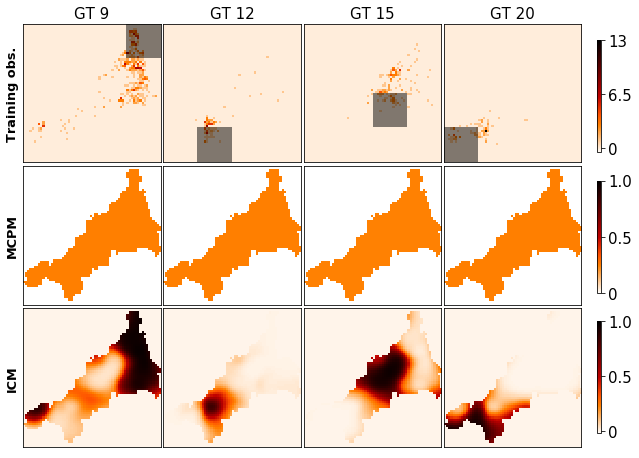

In [53]:
### cmap = 'jet'
cmap = "gist_heat_r"

inducing = 'ind'
f, ((ax01,ax02,ax03,ax04),(ax3, ax5, ax7, ax9),(ax10,ax11,ax12,ax13)) = plt.subplots(3, 4, sharex = 'col', sharey = 'row')

xmin, xmax, ymin, ymax = np.amin(data_final_with_na[fold,:,1]), np.amax(data_final_with_na[fold,:,1]), np.amin(data_final_with_na[fold,:,0]), np.amax(data_final_with_na[fold,:,0])
extent = xmin, xmax, ymin, ymax

f.set_figheight(7.8)
f.set_figwidth(10)


color_max = np.amax(((((outputs[:,0].reshape(N,N))*cell_inside)[~np.isnan(outputs[:,0].reshape(N,N)*cell_inside)],
                                    (outputs[:,1].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,1].reshape(N,N)*cell_inside)],
                                    (outputs[:,2].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,2].reshape(N,N)*cell_inside)],
                                    (outputs[:,3].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,3].reshape(N,N)*cell_inside)])))

color_min = np.amin((((outputs[:,0].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,0].reshape(N,N)*cell_inside)],
                                    (outputs[:,1].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,1].reshape(N,N)*cell_inside)],
                                    (outputs[:,2].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,2].reshape(N,N)*cell_inside)],
                                    (outputs[:,3].reshape(N,N)*cell_inside)[~np.isnan(outputs[:,3].reshape(N,N)*cell_inside)])))
color_min = color_min - 0.5

masked_array1 = np.ma.array(na_task1, mask=np.isnan(outputs[:,0].reshape(N,N)))
masked_array2 = np.ma.array(na_task2, mask=np.isnan(outputs[:,1].reshape(N,N)))
masked_array3 = np.ma.array(na_task3, mask=np.isnan(outputs[:,2].reshape(N,N)))
masked_array4 = np.ma.array(na_task4, mask=np.isnan(outputs[:,3].reshape(N,N)))


#### DATA

ax01.imshow(outputs[:,0].reshape(N,N)*cell_inside, 
                 aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
          extent=extent)

ax01.imshow(masked_array1, interpolation='nearest', cmap = cmap1, alpha = transparency,
          extent=extent)

ax01.set_yticks([]) 
ax01.set_xticks([]) 
ax01.set_title('GT 9', size=15)
ax01.set_ylabel('Training obs.', fontweight="bold")



ax02.imshow(outputs[:,1].reshape(N,N)*cell_inside, 
                 aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
          extent=extent)

ax02.imshow(masked_array2, interpolation='nearest', cmap = cmap1, alpha = transparency,
          extent=extent)
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax02.set_yticks([]) 
ax02.set_xticks([]) 
#ax2.title.set_text('GT 12')
ax02.set_title('GT 12', size=15)


ax03.imshow(outputs[:,2].reshape(N,N)*cell_inside, 
                 aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
          extent=extent)

ax03.imshow(masked_array3, interpolation='nearest', cmap = cmap1, alpha = transparency,
          extent=extent)
# ax3.spines['top'].set_visible(False)
# ax3.spines['right'].set_visible(False)
ax03.set_yticks([]) 
ax03.set_xticks([]) 
#ax3.title.set_text('GT 15')
ax03.set_title('GT 15', size=15)



img = ax04.imshow(outputs[:,3].reshape(N,N)*cell_inside, 
                 aspect = 'auto', cmap=cmap, interpolation=plot_interpolation, vmin = color_min, vmax = (color_max),
          extent=extent)

ax04.imshow(masked_array4, interpolation='nearest', cmap = cmap1, alpha = transparency,
          extent=extent)
# ax4.spines['top'].set_visible(False)
# ax4.spines['right'].set_visible(False)

ax04.set_yticks([]) 
ax04.set_xticks([]) 
ax04.set_title('GT 20', size=15)
# ax4.title.set_text('GT 20', size=20)

bounds = [0, 6.5, 13.0]
cax = f.add_axes([0.9, 0.65, 0.05, 0.2], aspect=30)
cbar = plt.colorbar(img, cax=cax, ticks = bounds)
cbar.ax.set_yticklabels(['0', '6.5', '13'])  # vertically oriented colorbar
cbar.ax.tick_params(labelsize=15)


#### MT predictions


color_max = 1.0
color_min = 0.0

im1 = ax3.imshow(cp1_MTCP* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax3.grid(False)
ax3.xaxis.set_visible(True)
ax3.tick_params(labelsize=8)
#ax3.title.set_text('GT 9')
ax3.set_yticks([]) 
ax3.set_xticks([]) 
ax3.set_ylabel('MCPM', fontweight="bold")




ax5.imshow(cp2_MTCP* cell_inside, extent=extent, 
           aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax5.grid(False)
ax5.xaxis.set_visible(True)
ax5.tick_params(labelsize=8)
#ax5.title.set_text('GT 12')
ax5.set_yticks([]) 
ax5.set_xticks([]) 




ax7.imshow(cp3_MTCP* cell_inside, extent=extent, 
           aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax7.grid(False)
ax7.xaxis.set_visible(True)
ax7.tick_params(labelsize=8)
#ax7.title.set_text('GT 15')
ax7.set_yticks([]) 
ax7.set_xticks([]) 



ax9.imshow(cp4_MTCP* cell_inside, extent=extent, 
           aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax9.grid(False)
ax9.xaxis.set_visible(True)
ax9.tick_params(labelsize=8)
#ax9.title.set_text('GT 20')
ax9.set_yticks([]) 
ax9.set_xticks([]) 


bounds = [0, 0.5, 1]
cax2 = f.add_axes([0.9, 0.40, 0.05, 0.2], aspect=30)
cbar = plt.colorbar(im1, cax=cax2, ticks = bounds)
cbar.ax.set_yticklabels(['0', '0.5', '1.0'])  # vertically oriented colorbar
cbar.ax.tick_params(labelsize=15)

#### Predictions ST
color_max = 1.0
color_min = 0.0 -0.02

im2 = ax10.imshow(cp1_ICM* cell_inside, 
                  extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
                  vmin = color_min, vmax = color_max)
ax10.grid(False)
ax10.xaxis.set_visible(True)
ax10.tick_params(labelsize=8)
ax10.set_yticks([]) 
ax10.set_xticks([]) 
ax10.set_ylabel('ICM', fontweight="bold")


ax11.imshow(cp2_ICM* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax11.grid(False)
ax11.xaxis.set_visible(True)
ax11.tick_params(labelsize=8)
ax11.set_yticks([]) 
ax11.set_xticks([]) 



ax12.imshow(cp3_ICM* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax12.grid(False)
ax12.xaxis.set_visible(True)
ax12.tick_params(labelsize=8)
ax12.set_yticks([]) 
ax12.set_xticks([]) 


ax13.imshow(cp4_ICM* cell_inside, extent=extent, aspect = 'auto', cmap=cmap, interpolation=plot_interpolation,
          vmin = color_min, vmax = color_max)
ax13.grid(False)
ax13.xaxis.set_visible(True)
ax13.tick_params(labelsize=8)
ax13.set_yticks([]) 
ax13.set_xticks([]) 



bounds = [0, 0.5, 1.0]
cax2 = f.add_axes([0.9, 0.15, 0.05, 0.2], aspect=30)
cbar = plt.colorbar(im2, cax=cax2, ticks = bounds)
cbar.ax.set_yticklabels(['0', '0.5', '1.0'])  # vertically oriented colorbar
cbar.ax.tick_params(labelsize=15)


f.subplots_adjust(hspace=0.02)
f.subplots_adjust(wspace=0.02)


#name = "BTB_missing_exp_intensity_LGCPN_ICM"+ inducing + str(cmap)
#f.savefig(name + '.png')

plt.show()

# Alternative computation of NLPL

In [58]:
## Use this if you want to compute the nlpl values by sampling from the posterior distributions

In [56]:
# Import outputs with missing data
n_folds = 16
method = 'MT'
prior_mixing_weights = 'Normal'
missing_exp = True
data_final_with_na = np.loadtxt('../Data/btb_experiments/' + 'data_final_with_na_'+ prior_mixing_weights + "_" + method+ "_" + str(missing_exp)).reshape(n_folds, N_all, n_tasks + inputs_dimension)


In [57]:
# Alternative computation of NLPL for MT
n_samples = 1
intensity_sample = np.zeros((n_folds, n_samples, N_all, n_tasks))
latent_fun_sample = np.zeros((n_folds, n_samples, N_all, n_latent))
weights_sample = np.zeros((n_folds, n_samples, n_latent, n_tasks))
nlpl_fold_task = np.zeros((n_folds, n_samples, n_tasks))
first_std = np.zeros((n_folds, n_tasks))
first_mean = np.zeros((n_folds, n_tasks))
std = np.zeros(( n_tasks))
mean = np.zeros((n_tasks))
for fold in xrange(n_folds):
    for task in xrange(n_tasks):
        latent_means = latent_means_MT_Normal[fold]    
        latent_vars = latent_vars_MT_Normal[fold]
        means_w = means_w_MT_Normal[fold]
        vars_w = vars_w_MT_Normal[fold]
        np.random.seed(1)
        latent_fun_sample[fold] = np.random.normal(latent_means, np.sqrt(latent_vars), size = (n_samples, N_all, n_latent)) 
        np.random.seed(2)
        weights_sample[fold] = np.random.normal(means_w, np.sqrt(vars_w), size = (n_samples, n_latent, n_tasks))


ValueError: size is not compatible with inputs

In [62]:
for fold in xrange(n_folds):
    for i in xrange(n_samples):
        intensity_sample[fold, i] = np.exp(np.transpose(np.dot(np.transpose(weights_sample[fold, i]), np.transpose(latent_fun_sample[fold, i]))) + offsets_MT_Normal[fold])
        

IndexError: index 1 is out of bounds for axis 0 with size 1

In [63]:
for fold in xrange(n_folds):
    for i in xrange(n_samples):
        for task in xrange(n_tasks):
            fold_task_subset = data_final_with_na[fold,:,task+inputs_dimension]
            #cond = np.isnan(fold_task_subset)

            cond = np.logical_and(cell_inside, np.isnan(fold_task_subset).reshape(N,N)).reshape(N_all,1)[:,0]

            true_counts =  outputs[cond,task]
            pred_counts = intensity_sample[fold, i, :,task][cond]
            if pred_counts.shape[0] == 0:
                nlpl_fold_task[fold,i,task] = np.nan
            else:
                nlpl_fold_task[fold,i,task] = - np.sum(poisson.logpmf(true_counts, pred_counts))/pred_counts.shape[0]  

for f in xrange(n_folds):
    for t in xrange(n_tasks):
#         print('f', f)
#         print('t', t)
        first_std[f,t] = np.std(nlpl_fold_task[f, :, t][~np.isnan(nlpl_fold_task[f, :, t])])
#         print('first_std', first_std[f,t])
        first_mean[f,t] = np.mean(nlpl_fold_task[f, :, t][~np.isnan(nlpl_fold_task[f, :, t])])
#         print('first_mean', first_mean[f,t])
        
for t in xrange(n_tasks):
    std[t] = np.std(first_mean[:,t][~np.isnan(first_mean[:,t])])/np.sqrt(n_folds)
    mean[t] = np.mean(first_mean[:,t][~np.isnan(first_mean[:,t])])



/home/virginia/.local/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/virginia/.local/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/virginia/.local/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/virginia/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/virginia/.local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/virginia/.local/lib/python2.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [67]:
std

array([nan, nan, nan, nan])

In [68]:
mean

array([inf, inf, inf, inf])